In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/intel-mobileodt-cervical-cancer-screening/sample_submission.csv
/kaggle/input/intel-mobileodt-cervical-cancer-screening/sample_submission_stg2.csv
/kaggle/input/intel-mobileodt-cervical-cancer-screening/test_stg2.7z
/kaggle/input/intel-mobileodt-cervical-cancer-screening/fixed_labels_v2.csv
/kaggle/input/intel-mobileodt-cervical-cancer-screening/solution_stg1_release.csv
/kaggle/input/intel-mobileodt-cervical-cancer-screening/test_stg2_7z_password.txt
/kaggle/input/intel-mobileodt-cervical-cancer-screening/removed_files.csv
/kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_3_v2/Type_3/6234.jpg
/kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_3_v2/Type_3/2081.jpg
/kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_3_v2/Type_3/3919.jpg
/kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_3_v2/Type_3/6399.jpg
/kaggle/input/intel-mobileodt-cervical-cancer-screening/additional_Type_3_v2/Type_3/

In [30]:
import numpy as np
import pandas as pd

from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, AveragePooling2D, Dense, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization 
from tensorflow.keras.utils import to_categorical

from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.applications.vgg16 import VGG16
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

from tqdm import tqdm

# 데이터

In [ ]:
label = pd.read_csv("../input/intel-mobileodt-cervical-cancer-screening/fixed_labels_v2.csv")
label

In [16]:
root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
train_dir = os.path.join(root_dir,'train', 'train')

type1_dir = os.path.join(train_dir, 'Type_1')
type2_dir = os.path.join(train_dir, 'Type_2')
type3_dir = os.path.join(train_dir, 'Type_3')

train_type1_files = glob.glob(type1_dir+'/*.jpg')
train_type2_files = glob.glob(type2_dir+'/*.jpg')
train_type3_files = glob.glob(type3_dir+'/*.jpg')

added_type1_files  =  glob.glob(os.path.join(root_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(root_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(root_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')


type1_files = train_type1_files + added_type1_files
type2_files = train_type2_files + added_type2_files
type3_files = train_type3_files + added_type3_files

print(f'''Type 1 files for training: {len(type1_files)} 
Type 2 files for training: {len(type2_files)}
Type 3 files for training: {len(type3_files)}''' )

Type 1 files for training: 1441 
Type 2 files for training: 4348
Type 3 files for training: 2426


In [17]:
files = {'filepath': type1_files + type2_files + type3_files,
          'label': ['Type 1']* len(type1_files) + ['Type 2']* len(type2_files) + ['Type 3']* len(type3_files)}

files_df = pd.DataFrame(files).sample(frac=1, random_state= 1).reset_index(drop=True)
files_df

,filepath,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
2,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
4,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
...,...,...
8210,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
8211,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
8212,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
8213,../input/intel-mobileodt-cervical-cancer-scree...,Type 2


In [18]:
files_df = pd.read_csv('../input/resize128/dropfiles.csv', sep=',').drop('Unnamed: 0', axis=1)
files_df

,filepath,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
2,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
4,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
...,...,...
8207,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
8208,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
8209,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
8210,../input/intel-mobileodt-cervical-cancer-scree...,Type 2


# 데이터 분리

# 데이터 전처리

In [14]:
X_train = np.load("../input/resize128/X_train_128.npy",allow_pickle=True)
X_valid = np.load("../input/resize128/X_valid_128.npy",allow_pickle=True)
y_train = np.load("../input/resize128/y_train_128.npy",allow_pickle=True)
y_valid = np.load("../input/resize128/y_valid_128.npy",allow_pickle=True)

In [15]:
# X train data 확인
X_train[0]

array([[[ 71,  81,  90],
        [ 79,  89,  97],
        [ 88, 101, 106],
        ...,
        [ 87,  57,  81],
        [ 90,  58,  82],
        [ 87,  55,  78]],

       [[ 82,  89,  97],
        [ 88,  95, 101],
        [ 96, 107, 111],
        ...,
        [100,  66,  93],
        [ 99,  65,  92],
        [ 93,  60,  88]],

       [[ 79,  83,  94],
        [ 93,  98, 104],
        [107, 114, 120],
        ...,
        [102,  67, 100],
        [ 99,  64,  96],
        [ 98,  63,  93]],

       ...,

       [[ 94,  62,  86],
        [ 75,  47,  69],
        [ 64,  43,  58],
        ...,
        [ 70,  37,  44],
        [ 69,  37,  48],
        [ 67,  36,  51]],

       [[110,  74, 100],
        [ 89,  57,  81],
        [ 77,  49,  71],
        ...,
        [ 53,  24,  28],
        [ 60,  30,  40],
        [ 65,  36,  54]],

       [[120,  84, 110],
        [108,  75,  99],
        [ 95,  63,  87],
        ...,
        [ 51,  23,  35],
        [ 60,  29,  47],
        [ 78,  46,  72]]

In [12]:
# X validation data 확인
X_valid[0]

array([[[ 71,  81,  90],
        [ 79,  89,  97],
        [ 88, 101, 106],
        ...,
        [ 87,  57,  81],
        [ 90,  58,  82],
        [ 87,  55,  78]],

       [[ 82,  89,  97],
        [ 88,  95, 101],
        [ 96, 107, 111],
        ...,
        [100,  66,  93],
        [ 99,  65,  92],
        [ 93,  60,  88]],

       [[ 79,  83,  94],
        [ 93,  98, 104],
        [107, 114, 120],
        ...,
        [102,  67, 100],
        [ 99,  64,  96],
        [ 98,  63,  93]],

       ...,

       [[ 94,  62,  86],
        [ 75,  47,  69],
        [ 64,  43,  58],
        ...,
        [ 70,  37,  44],
        [ 69,  37,  48],
        [ 67,  36,  51]],

       [[110,  74, 100],
        [ 89,  57,  81],
        [ 77,  49,  71],
        ...,
        [ 53,  24,  28],
        [ 60,  30,  40],
        [ 65,  36,  54]],

       [[120,  84, 110],
        [108,  75,  99],
        [ 95,  63,  87],
        ...,
        [ 51,  23,  35],
        [ 60,  29,  47],
        [ 78,  46,  72]]

In [19]:
# 정규화 (0과1사이의값)
X_train = X_train/255
X_valid = X_valid/255

In [20]:
# 정규화한 X train data 확인
X_train[0]

array([[[0.27843137, 0.31764706, 0.35294118],
        [0.30980392, 0.34901961, 0.38039216],
        [0.34509804, 0.39607843, 0.41568627],
        ...,
        [0.34117647, 0.22352941, 0.31764706],
        [0.35294118, 0.22745098, 0.32156863],
        [0.34117647, 0.21568627, 0.30588235]],

       [[0.32156863, 0.34901961, 0.38039216],
        [0.34509804, 0.37254902, 0.39607843],
        [0.37647059, 0.41960784, 0.43529412],
        ...,
        [0.39215686, 0.25882353, 0.36470588],
        [0.38823529, 0.25490196, 0.36078431],
        [0.36470588, 0.23529412, 0.34509804]],

       [[0.30980392, 0.3254902 , 0.36862745],
        [0.36470588, 0.38431373, 0.40784314],
        [0.41960784, 0.44705882, 0.47058824],
        ...,
        [0.4       , 0.2627451 , 0.39215686],
        [0.38823529, 0.25098039, 0.37647059],
        [0.38431373, 0.24705882, 0.36470588]],

       ...,

       [[0.36862745, 0.24313725, 0.3372549 ],
        [0.29411765, 0.18431373, 0.27058824],
        [0.25098039, 0

In [21]:
# 정규화한 X validation data 확인
X_valid[0]

array([[[0.23137255, 0.2       , 0.28235294],
        [0.22352941, 0.19215686, 0.2627451 ],
        [0.23137255, 0.20392157, 0.2745098 ],
        ...,
        [0.11372549, 0.15294118, 0.19607843],
        [0.08627451, 0.12156863, 0.15294118],
        [0.10980392, 0.14117647, 0.17647059]],

       [[0.23921569, 0.20784314, 0.28235294],
        [0.2627451 , 0.21960784, 0.29803922],
        [0.26666667, 0.21176471, 0.30196078],
        ...,
        [0.08627451, 0.15686275, 0.18823529],
        [0.09803922, 0.15294118, 0.18823529],
        [0.10196078, 0.1372549 , 0.17647059]],

       [[0.2745098 , 0.23921569, 0.31372549],
        [0.2627451 , 0.23137255, 0.28627451],
        [0.27843137, 0.23137255, 0.30980392],
        ...,
        [0.09803922, 0.14901961, 0.21176471],
        [0.10588235, 0.15294118, 0.2       ],
        [0.10980392, 0.14509804, 0.18431373]],

       ...,

       [[0.37254902, 0.34117647, 0.43137255],
        [0.39607843, 0.36470588, 0.45882353],
        [0.45098039, 0

In [22]:
# train 개수, 차원 확인
print(len(X_train), len(y_train))
print(X_train.shape)

6569 6569
(6569, 128, 128, 3)


In [23]:
# validation 개수, 차원 확인
print(len(X_valid), len(y_valid))
print(X_valid.shape)

1643 1643
(1643, 128, 128, 3)


In [24]:
# y 라벨링 (string -> int)
le = LabelEncoder().fit(['Type 1', 'Type 2', 'Type 3'])
y_train = le.transform(y_train)
y_valid = le.transform(y_valid)

y_train_onehot = to_categorical(y_train, num_classes=3)
y_valid_onehot = to_categorical(y_valid, num_classes=3)

In [25]:
y_train_onehot[:5]

array([[0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [26]:
y_valid_onehot[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.]], dtype=float32)

In [36]:
print(len(X_train), len(y_train), len(X_valid), len(y_valid))

6569 6569 1643 1643


In [27]:
np.unique(y_train)

array([0, 1, 2])

# Augmentation

In [34]:
# ImageDataGenerator 세팅
train_datagen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip=True,
                                vertical_flip = True)

eval_datagen = ImageDataGenerator()

In [35]:
# apply data augmentation to features
BATCH_SIZE= 16
train_gen = train_datagen.flow(X_train, y_train_onehot, batch_size= BATCH_SIZE)
val_gen = eval_datagen.flow(X_valid, y_valid_onehot, batch_size= BATCH_SIZE)

In [39]:
# non-augmentation
train_gen_non = ImageDataGenerator().flow(X_train, y_train_onehot, batch_size = BATCH_SIZE)
valid_gen_non = ImageDataGenerator().flow(X_valid, y_valid_onehot, batch_size = BATCH_SIZE)

In [36]:
# define training steps
TRAIN_STEPS = len(X_train)//BATCH_SIZE
VAL_STEPS = len(X_valid)//BATCH_SIZE

In [37]:
# show shape of each  batch
for data_batch, labels_batch in train_gen:
    print('data batch shape: {} \n labels batch shape: {}'.format(data_batch.shape, labels_batch.shape))
    break

data batch shape: (16, 128, 128, 3) 
 labels batch shape: (16, 3)


In [38]:
print(len(train_gen), len(val_gen))

411 103


# Modling

### ResNet18

In [28]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-5)

early_stopping = EarlyStopping(monitor='val_loss', patience = 20, verbose=1, mode='min', restore_best_weights= True)

checkpoint = ModelCheckpoint('cervicalModel.weights.hdf5', monitor='val_loss', verbose=1,save_best_only=True, mode= 'min')

checkpoint_ag = ModelCheckpoint('resnet18.weights.hdf5', monitor='val_accuracy', verbose=1,save_best_only=True, mode= 'max')

In [55]:
import tensorflow as tf
tf.config.list_logical_devices()

2022-11-22 05:43:12.509451: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 05:43:12.612092: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 05:43:12.612908: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-22 05:43:12.625410: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

#### 1) non-augmentation

In [53]:
resnet18 = Sequential([
    keras.Input(shape=(128, 128, 3)),
    
    Conv2D(512, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(256, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(128, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dense(3, activation='softmax')
    
])

resnet18.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 128, 512)     14336     
_________________________________________________________________
batch_normalization_9 (Batch (None, 128, 128, 512)     2048      
_________________________________________________________________
activation_11 (Activation)   (None, 128, 128, 512)     0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 512)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 64, 64, 256)       1179904   
_________________________________________________________________
batch_normalization_10 (Batc (None, 64, 64, 256)       1024      
_________________________________________________________________
activation_12 (Activation)   (None, 64, 64, 256)      

In [22]:
resnet18.compile(
  optimizer = 'adam',
  loss = 'categorical_crossentropy',
  metrics = ['Accuracy'],
)

history_resnet18 = resnet18.fit(
    train_gen_non
    , steps_per_epoch= TRAIN_STEPS
    , validation_data=valid_gen_non
    , validation_steps=VAL_STEPS
    , epochs= 100
    , callbacks= [reduceLR, early_stopping, checkpoint]
)

Epoch 1/100
410/410 [==============================] - 27s 64ms/step - loss: 0.3190 - Accuracy: 0.8715 - val_loss: 1.1570 - val_Accuracy: 0.6256

Epoch 00001: val_loss did not improve from 0.88262
Epoch 2/100
410/410 [==============================] - 26s 64ms/step - loss: 0.2713 - Accuracy: 0.8947 - val_loss: 1.2594 - val_Accuracy: 0.5974

Epoch 00002: val_loss did not improve from 0.88262
Epoch 3/100
410/410 [==============================] - 26s 64ms/step - loss: 0.2763 - Accuracy: 0.8906 - val_loss: 1.7184 - val_Accuracy: 0.6121

Epoch 00003: val_loss did not improve from 0.88262
Epoch 4/100
410/410 [==============================] - 26s 64ms/step - loss: 0.2263 - Accuracy: 0.9129 - val_loss: 1.5803 - val_Accuracy: 0.6287

Epoch 00004: val_loss did not improve from 0.88262
Epoch 5/100
410/410 [==============================] - 26s 64ms/step - loss: 0.2125 - Accuracy: 0.9155 - val_loss: 1.5963 - val_Accuracy: 0.6324

Epoch 00005: val_loss did not improve from 0.88262
Epoch 6/100
410

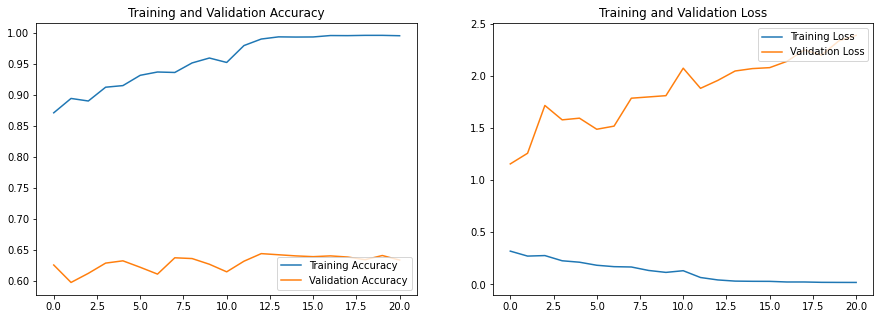

In [23]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_resnet18.history['Accuracy'], label='Training Accuracy')
plt.plot(history_resnet18.history['val_Accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_resnet18.history['loss'], label='Training Loss')
plt.plot(history_resnet18.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#### 2) augmentation

In [22]:
resnet18.compile(
  optimizer = 'adam',
  loss = 'categorical_crossentropy',
  metrics = ['Accuracy'],
)

history_resnet18_ag = resnet18.fit(
    train_gen
    , steps_per_epoch= TRAIN_STEPS
    , validation_data=val_gen
    , validation_steps=VAL_STEPS
    , epochs= 100
    , callbacks= [reduceLR, early_stopping, checkpoint_ag]
)

2022-11-22 05:55:41.825951: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/100


2022-11-22 05:55:43.645540: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


410/410 [==============================] - 44s 87ms/step - loss: 1.0982 - Accuracy: 0.5101 - val_loss: 0.9976 - val_Accuracy: 0.5300
Epoch 2/100
410/410 [==============================] - 35s 85ms/step - loss: 0.9982 - Accuracy: 0.5289 - val_loss: 0.9959 - val_Accuracy: 0.5300
Epoch 3/100
410/410 [==============================] - 35s 86ms/step - loss: 0.9937 - Accuracy: 0.5283 - val_loss: 0.9894 - val_Accuracy: 0.5300
Epoch 4/100
410/410 [==============================] - 35s 86ms/step - loss: 0.9812 - Accuracy: 0.5286 - val_loss: 0.9958 - val_Accuracy: 0.5294
Epoch 5/100
410/410 [==============================] - 35s 85ms/step - loss: 0.9776 - Accuracy: 0.5288 - val_loss: 0.9824 - val_Accuracy: 0.5282
Epoch 6/100
410/410 [==============================] - 35s 86ms/step - loss: 0.9679 - Accuracy: 0.5280 - val_loss: 0.9813 - val_Accuracy: 0.5300
Epoch 7/100
410/410 [==============================] - 35s 85ms/step - loss: 0.9676 - Accuracy: 0.5269 - val_loss: 0.9721 - val_Accuracy: 0.53

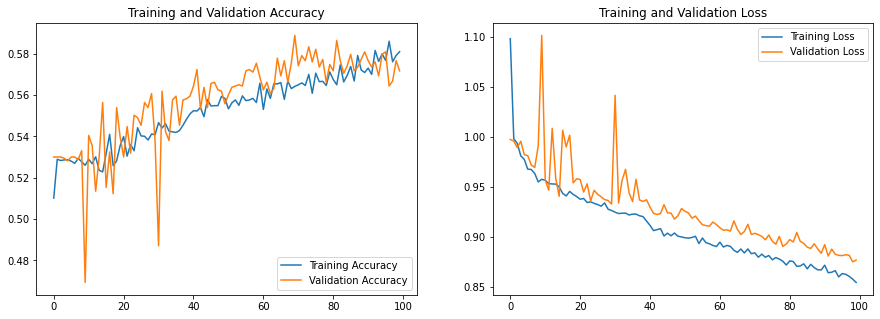

In [23]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_resnet18_ag.history['Accuracy'], label='Training Accuracy')
plt.plot(history_resnet18_ag.history['val_Accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_resnet18_ag.history['loss'], label='Training Loss')
plt.plot(history_resnet18_ag.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### ResNet18 - average pooling

#### non-augmentation

In [31]:
resnet18_avg = Sequential([
    keras.Input(shape=(128, 128, 3)),
    
    Conv2D(512, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size=2, strides=None),
    
    Conv2D(256, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size=2, strides=None),
    
    Conv2D(128, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size=2, strides=None),

    Conv2D(64, kernel_size = (3,3), padding='same', kernel_initializer='random_normal'),
    BatchNormalization(),
    Activation('relu'),
    AveragePooling2D(pool_size=2, strides=None),

    Flatten(),
    Dense(64, kernel_initializer='random_normal'),
    Activation('relu'),
    Dense(3, activation='softmax')
    
])

resnet18_avg.summary()

2022-11-24 05:41:54.416200: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 05:41:54.514959: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 05:41:54.515806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 05:41:54.517248: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 512)     14336     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 512)     2048      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 128, 512)     0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 64, 64, 512)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 256)       1179904   
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 256)       1024      
_________________________________________________________________
activation_2 (Activation)    (None, 64, 64, 256)       0

ead from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-24 05:41:56.889146: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15401 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [41]:
resnet18_avg.compile(
  optimizer = 'adam',
  loss = 'categorical_crossentropy',
  metrics = ['Accuracy'],
)

history_resnet18_avg = resnet18_avg.fit(
    train_gen_non
    , steps_per_epoch= TRAIN_STEPS
    , validation_data=valid_gen_non
    , validation_steps=VAL_STEPS
    , epochs= 100
    , callbacks= [reduceLR, early_stopping, checkpoint]
)

Epoch 1/30
410/410 [==============================] - 27s 65ms/step - loss: 0.9598 - Accuracy: 0.5282 - val_loss: 0.9715 - val_Accuracy: 0.5184

Epoch 00001: val_loss did not improve from 0.96191
Epoch 2/30
410/410 [==============================] - 27s 65ms/step - loss: 0.9275 - Accuracy: 0.5314 - val_loss: 0.9483 - val_Accuracy: 0.5282

Epoch 00002: val_loss improved from 0.96191 to 0.94832, saving model to cervicalModel.weights.hdf5
Epoch 3/30
410/410 [==============================] - 26s 65ms/step - loss: 0.9065 - Accuracy: 0.5393 - val_loss: 0.9587 - val_Accuracy: 0.5472

Epoch 00003: val_loss did not improve from 0.94832
Epoch 4/30
410/410 [==============================] - 26s 65ms/step - loss: 0.8925 - Accuracy: 0.5365 - val_loss: 0.9206 - val_Accuracy: 0.5466

Epoch 00004: val_loss improved from 0.94832 to 0.92057, saving model to cervicalModel.weights.hdf5
Epoch 5/30
410/410 [==============================] - 27s 65ms/step - loss: 0.8776 - Accuracy: 0.5423 - val_loss: 0.9426

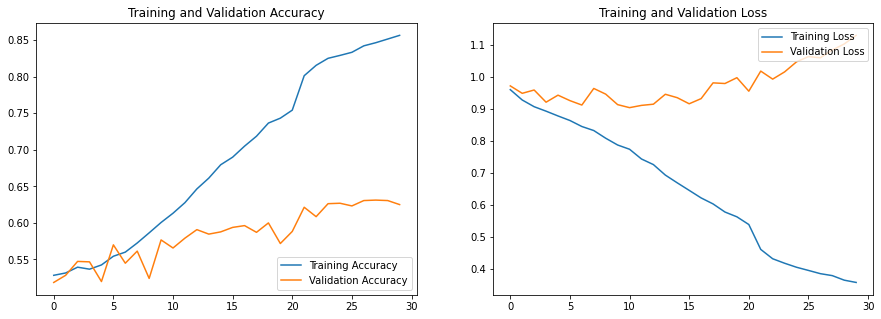

In [42]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_resnet18_avg.history['Accuracy'], label='Training Accuracy')
plt.plot(history_resnet18_avg.history['val_Accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_resnet18_avg.history['loss'], label='Training Loss')
plt.plot(history_resnet18_avg.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

#### augmentation

In [43]:
resnet18_avg.compile(
  optimizer = 'adam',
  loss = 'categorical_crossentropy',
  metrics = ['Accuracy'],
)

history_resnet18_avg_ag = resnet18_avg.fit(
    train_gen
    , steps_per_epoch= TRAIN_STEPS
    , validation_data=val_gen
    , validation_steps=VAL_STEPS
    , epochs= 100
    , callbacks= [reduceLR, early_stopping, checkpoint_ag]
)

Epoch 1/30
410/410 [==============================] - 35s 83ms/step - loss: 1.2019 - Accuracy: 0.3362 - val_loss: 1.0341 - val_Accuracy: 0.4234
Epoch 2/30
410/410 [==============================] - 34s 83ms/step - loss: 1.0277 - Accuracy: 0.4834 - val_loss: 0.9603 - val_Accuracy: 0.5300
Epoch 3/30
410/410 [==============================] - 34s 84ms/step - loss: 0.9822 - Accuracy: 0.5300 - val_loss: 0.9461 - val_Accuracy: 0.5300
Epoch 4/30
410/410 [==============================] - 34s 84ms/step - loss: 0.9677 - Accuracy: 0.5317 - val_loss: 0.9277 - val_Accuracy: 0.5233
Epoch 5/30
410/410 [==============================] - 34s 83ms/step - loss: 0.9550 - Accuracy: 0.5295 - val_loss: 0.9265 - val_Accuracy: 0.5325
Epoch 6/30
410/410 [==============================] - 34s 83ms/step - loss: 0.9508 - Accuracy: 0.5257 - val_loss: 0.9393 - val_Accuracy: 0.5159
Epoch 7/30
410/410 [==============================] - 34s 83ms/step - loss: 0.9450 - Accuracy: 0.5250 - val_loss: 0.9461 - val_Accuracy:

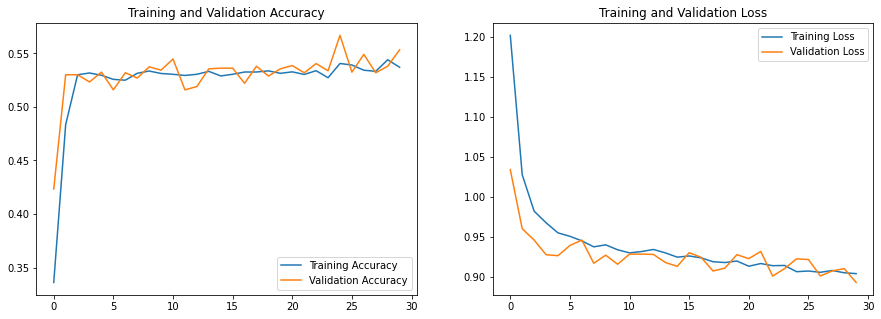

In [44]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history_resnet18_avg_ag.history['Accuracy'], label='Training Accuracy')
plt.plot(history_resnet18_avg_ag.history['val_Accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history_resnet18_avg_ag.history['loss'], label='Training Loss')
plt.plot(history_resnet18_avg_ag.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [48]:
y_pred_enc = resnet18.predict(X_valid)          # one-hot encoding된 label 예측값
y_pred = [np.argmax(i) for i in y_pred_enc] # label 예측값
item = {
      0: 'Type1'
    , 1: 'Type2'
    , 2: 'Type3'
}

matrix = confusion_matrix(y_valid, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

2022-11-24 06:42:43.016628: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 323026944 exceeds 10% of free system memory.
2022-11-24 06:42:43.559901: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 323026944 exceeds 10% of free system memory.


,Type1,Type2,Type3
Type1,0,274,14
Type2,0,844,26
Type3,0,465,20


In [51]:
y_pred_enc = resnet18_ag.predict(X_valid)          # one-hot encoding된 label 예측값
y_pred = [np.argmax(i) for i in y_pred_enc] # label 예측값
item = {
      0: 'Type1'
    , 1: 'Type2'
    , 2: 'Type3'
}

matrix = confusion_matrix(y_valid, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

NameError: name 'resnet18_ag' is not defined

In [49]:
y_pred_enc = resnet18.predict(X_valid)          # one-hot encoding된 label 예측값
y_pred = [np.argmax(i) for i in y_pred_enc] # label 예측값
item = {
      0: 'Type1'
    , 1: 'Type2'
    , 2: 'Type3'
}

matrix = confusion_matrix(y_valid, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

2022-11-24 06:43:39.680906: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 323026944 exceeds 10% of free system memory.
2022-11-24 06:43:40.185713: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 323026944 exceeds 10% of free system memory.


,Type1,Type2,Type3
Type1,48,217,23
Type2,43,673,154
Type3,4,292,189


In [54]:
y_pred_enc = resnet18_avg_ag.predict(X_valid)          # one-hot encoding된 label 예측값
y_pred = [np.argmax(i) for i in y_pred_enc] # label 예측값
item = {
      0: 'Type1'
    , 1: 'Type2'
    , 2: 'Type3'
}

matrix = confusion_matrix(y_valid, y_pred)
df = pd.DataFrame(matrix)
df.columns = item.values()
df.index = item.values()
        
df

NameError: name 'resnet18_avg_ag' is not defined

### reference

#### Testing model generator

In [45]:
print('Create and compile model...')

nb_classes = 3
img_rows, img_cols = conf['image_shape'][1], conf['image_shape'][0]
img_channels = 3

model = ResnetBuilder.build_resnet_34((img_channels, img_rows, img_cols), nb_classes)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#model.compile(loss='hinge',optimizer='adadelta',metrics=['accuracy'])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=conf['patience'], verbose=0),
    ModelCheckpoint('cervical_best.hdf5', monitor='val_loss', save_best_only=True, verbose=0),
]

print('Fit model...')
fit = model.fit_generator(generator=batch_generator_train(train_list, conf['batch_size']),
                      nb_epoch=conf['nb_epoch'],
                      #samples_per_epoch=len(train_list),
                      samples_per_epoch=100,
                      validation_data=batch_generator_train(valid_list, conf['batch_size']),
                      #nb_val_samples=len(valid_list),
                      nb_val_samples=50,
                      verbose=1,
                      callbacks=callbacks)

Create and compile model...


NameError: name 'conf' is not defined

#### Create submission files with prediction for submission